## Importing libraries

In [54]:
import sys, os, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
import logging

## Getting the data
You already collected the data and uploaded it to edge impulse. You could download the files generated from the dashboard section. Scroll down until you see the training data and download both the labels and the data numpy files. 

In [55]:
data_path = Path("../data/")
# Define data path
X_path = data_path / "ei-cherry_classification_test-image-X_training.npy" # name of the X_training file (Features)
Y_path = data_path / "ei-cherry_classification_test-image-y_training.npy" # name of the Y_training file (Labels)


# Load the data
X = np.load(X_path.resolve())
Y = np.load(Y_path.resolve())

print(Y.shape)
print(Y[:3])

Y= Y[:,0]

#data_shape
X.shape, Y.shape

(94, 4)
[[         1 1501788176          0          0]
 [         1 1501788156          0          0]
 [         1 1501788125          0          0]]


((94, 9216), (94,))

Reshape the image as desired

	 Label Image==>  1


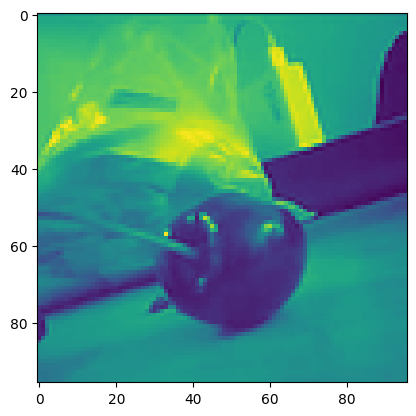

In [56]:
image = X[3]
label = Y[3]

print("\t Label Image==> ",label)
img = tf.reshape(image, (96,96,1)) # 32x32x3 channels
plt.imshow(img);

In [57]:
X[:1].shape
#Y[:1].shape

(1, 9216)

In [58]:

tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "cherry", "ducky" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)
#tf.keras.utils.to_categorical(Y, num_classes=2)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


In [59]:
SPECIFIC_INPUT_SHAPE = (96, 96, 1)
# model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', 
                 kernel_constraint=tf.keras.constraints.MaxNorm(1), 
                 padding='same',input_shape=SPECIFIC_INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
model.add(Dense(classes, activation='softmax', name='y_pred'))

# this controls the learning rate
opt = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
# This is only required for some input types, e.g. images

train_dataset = train_dataset.map(get_reshape_function(SPECIFIC_INPUT_SHAPE), tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.map(get_reshape_function(SPECIFIC_INPUT_SHAPE), tf.data.experimental.AUTOTUNE)


In [60]:
train_dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [61]:
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

print(train_dataset)


<_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>


In [62]:
# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset, verbose=2, callbacks=callbacks)


Epoch 1/10
3/3 - 1s - 173ms/step - accuracy: 0.6000 - loss: 1.5069 - val_accuracy: 0.7895 - val_loss: 0.5403
Epoch 2/10
3/3 - 0s - 36ms/step - accuracy: 0.6267 - loss: 0.6159 - val_accuracy: 0.3158 - val_loss: 0.7662
Epoch 3/10
3/3 - 0s - 36ms/step - accuracy: 0.6400 - loss: 0.6483 - val_accuracy: 0.7895 - val_loss: 0.4516
Epoch 4/10
3/3 - 0s - 36ms/step - accuracy: 0.6400 - loss: 0.5204 - val_accuracy: 0.7895 - val_loss: 0.4085
Epoch 5/10
3/3 - 0s - 40ms/step - accuracy: 0.6933 - loss: 0.4763 - val_accuracy: 0.8421 - val_loss: 0.3927
Epoch 6/10
3/3 - 0s - 37ms/step - accuracy: 0.8800 - loss: 0.4065 - val_accuracy: 0.9474 - val_loss: 0.4116
Epoch 7/10
3/3 - 0s - 36ms/step - accuracy: 0.9733 - loss: 0.3752 - val_accuracy: 0.8421 - val_loss: 0.3294
Epoch 8/10
3/3 - 0s - 37ms/step - accuracy: 0.9600 - loss: 0.3057 - val_accuracy: 0.8421 - val_loss: 0.2837
Epoch 9/10
3/3 - 0s - 36ms/step - accuracy: 0.9600 - loss: 0.2482 - val_accuracy: 0.9474 - val_loss: 0.2542
Epoch 10/10
3/3 - 0s - 36ms

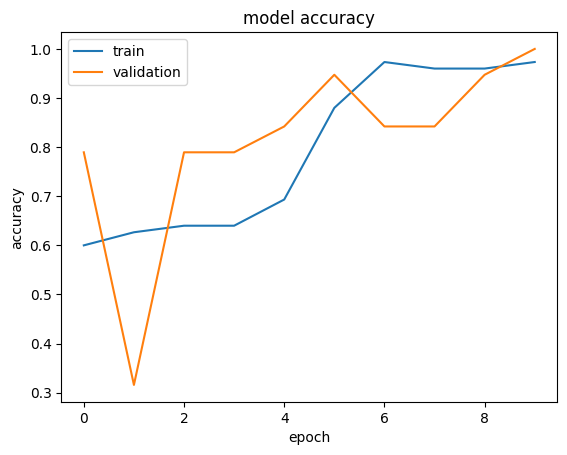

In [63]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [47]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 96, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     2,359,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ y_pred (Dense)                  │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,134,920 (27.22 MB)

 Trainable params: 2,378,306 (9.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,756,614 (18.15 MB)

In [64]:
# Save the model to disk
model.export('simple_model.zip')

Saved artifact at 'simple_model.zip'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='keras_tensor_92')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  14409252112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14409252304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14409252688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14409252496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14396359504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14396360848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14396359120: TensorSpec(shape=(), dtype=tf.float32, name=None)
  14396360464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14396361808: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [49]:
model_input = Sequential()
#model_input.add(Flatten()) # input tensor
model_input.add(model)
model_input.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (None, 2)              │     2,378,306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,378,306 (9.07 MB)

 Trainable params: 2,378,306 (9.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import edgeimpulse as ei

# Change to an API key from your Edge Impulse project
API_KEY = "ei_cfe4c7ec00c6c31d833ea8784e0b88744c1ec60ceafd339cf623664f7a68dd12"
ei.API_KEY = API_KEY

try:
    profile = ei.model.profile(model = "simple_model.zip", 
                               device="espressif-esp32",
                               
                              )
    print(profile.summary())
except:
    print(f"could not profile: ")